In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

2025-06-18 12:56:02.853037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750251363.063887      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750251363.120253      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<Axes: >

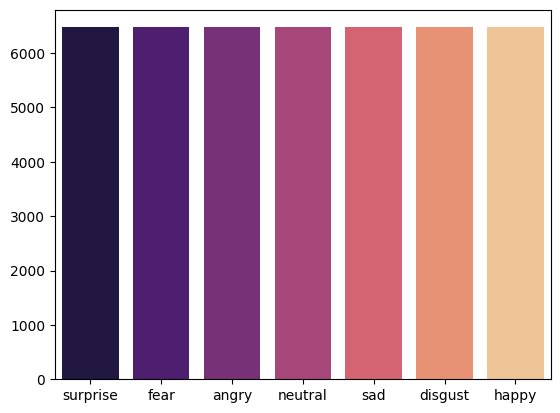

In [2]:
train_dir = '/kaggle/input/emoscan-dataset-2/train'
emotions = os.listdir(train_dir)

train_counts = []

for emotion in emotions:
    folder = os.path.join(train_dir, emotion)
    train_counts.append(len(os.listdir(folder)))
    
sns.barplot(x=emotions, y=train_counts, palette='magma')

<Axes: >

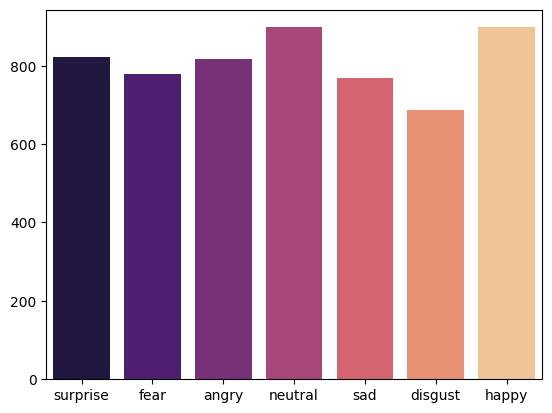

In [3]:
test_dir = '/kaggle/input/emoscan-dataset-2/test'

test_counts = []

for emotion in emotions:
    folder = os.path.join(test_dir, emotion)
    test_counts.append(len(os.listdir(folder)))
    
sns.barplot(x=emotions, y=test_counts, palette='magma')

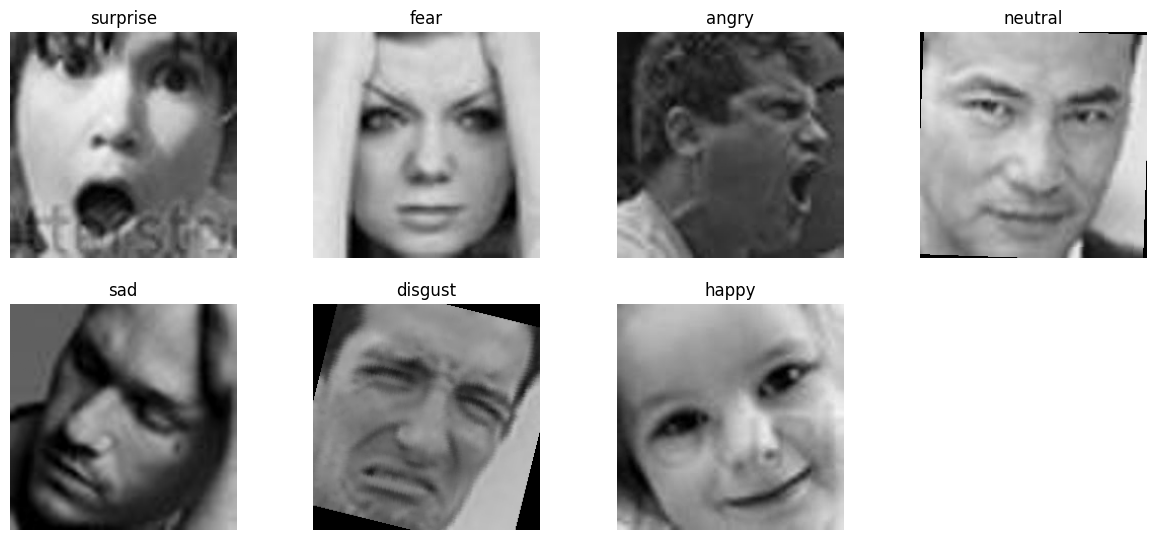

In [4]:
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [5]:
val_dir = '/kaggle/input/emoscan-dataset-2/val'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)


val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 45304 images belonging to 7 classes.
Found 11326 images belonging to 7 classes.
Found 5668 images belonging to 7 classes.


In [7]:
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}

In [96]:
input_shape = (224, 224, 3)


base_model = ResNet50V2(
    include_top=False,
    weights='/kaggle/input/resnet/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5',
    input_shape=input_shape
)


for layer in base_model.layers:
    layer.trainable = False


for layer in base_model.layers[-10:]:
    layer.trainable = True


model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(7, activation='softmax')  
])

In [97]:
optimizer = Adamax(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 2048)          │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,787,207 (94.56 MB)

 Trainable params: 4,634,375 (17.68 MB)

 Non-trainable params: 20,152,832 (76.88 MB)

In [10]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)
]


In [11]:
train_history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    class_weight=class_weights_dict,
    callbacks=callbacks
)


Epoch 1/20


I0000 00:00:1750251532.660812     127 service.cc:148] XLA service 0x7ae4f8002a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750251532.661999     127 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750251535.971396     127 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1416 ━━━━━━━━━━━━━━━━━━━━ 25:01:57 64s/step - accuracy: 0.1250 - loss: 2.0024

I0000 00:00:1750251556.707839     127 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1416/1416 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.2974 - loss: 1.7611
Epoch 1: val_accuracy improved from -inf to 0.51903, saving model to best_model.h5
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 852s 557ms/step - accuracy: 0.2974 - loss: 1.7609 - val_accuracy: 0.5190 - val_loss: 1.2614 - learning_rate: 1.0000e-04
Epoch 2/20
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.5317 - loss: 1.2378
Epoch 2: val_accuracy improved from 0.51903 to 0.56002, saving model to best_model.h5
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 651s 460ms/step - accuracy: 0.5317 - loss: 1.2377 - val_accuracy: 0.5600 - val_loss: 1.2129 - learning_rate: 1.0000e-04
Epoch 3/20
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6046 - loss: 1.0636
Epoch 3: val_accuracy improved from 0.56002 to 0.65926, saving model to best_model.h5
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 660s 466ms/step - accuracy: 0.6046 - loss: 1.0636 - val_accuracy: 0.6593 - val_loss: 0.8923 - learning_rate: 1.0000e-04
Epoch 4/20
1416/1416 ━━━━━━━━━━━━

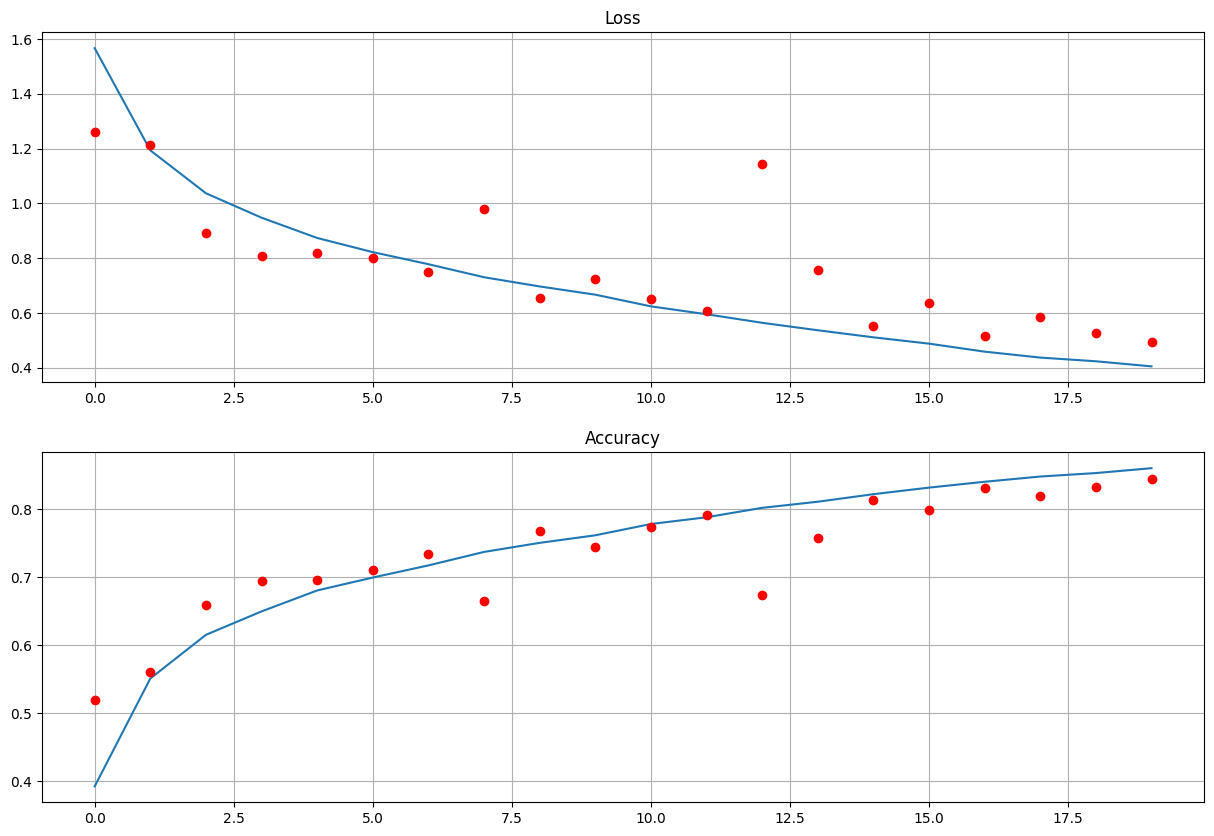

In [99]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'], 'ro')
plt.title('Loss')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(train_history.history['accuracy'])

plt.plot(train_history.history['val_accuracy'], 'ro')
plt.title('Accuracy')
plt.grid(True)

In [16]:
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

true_labels = test_generator.classes


steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

preds = model.predict(test_generator, steps=steps)

pred_labels = np.argmax(preds, axis=1)

classes = list(test_generator.class_indices.keys())


Found 5668 images belonging to 7 classes.
178/178 ━━━━━━━━━━━━━━━━━━━━ 48s 243ms/step


In [17]:
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       817
           1       0.99      1.00      1.00       686
           2       0.79      0.76      0.78       779
           3       0.91      0.88      0.89       898
           4       0.78      0.81      0.79       898
           5       0.73      0.71      0.72       769
           6       0.91      0.95      0.93       821

    accuracy                           0.85      5668
   macro avg       0.85      0.85      0.85      5668
weighted avg       0.85      0.85      0.85      5668

